# Set transpiler optimization level

Real quantum devices are subject to noise and gate errors, so optimizing the circuits to reduce their depth and gate count can significantly improve the results obtained from executing those circuits. The generate_preset_pass_manager function has one required positional argument, optimization_level, that controls how much effort the transpiler spends on optimizing circuits. This argument can be an integer taking one of the values 0, 1, 2, or 3. Higher optimization levels generate more optimized circuits at the expense of longer compile times. The following table explains the optimizations performed with each setting.

Optimization Level	- Description

0	    -            No optimization: typically used for hardware characterization
                    Basic translation
                    Layout/Routing: TrivialLayout, where it selects the same physical qubit numbers as virtual and inserts SWAPs to make it work (using StochasticSwap)


1	    -            Light optimization:
                    Layout/Routing: Layout is first attempted with TrivialLayout. If additional SWAPs are required, a layout with a minimum number of SWAPs is found by using SabreSWAP, then it uses VF2LayoutPostLayout to try to select the best qubits in the graph.
                    InverseCancellation
                    1Q gate optimization


2	    -            Medium optimization:
                    Layout/Routing: Optimization level 1 (without trivial) + heuristic optimized with greater search depth and trials of optimization function. Because TrivialLayout is not used, there is no attempt to use the same physical and virtual qubit numbers.
                    CommutativeCancellation


3	    -            High Optimization:
                    Optimization level 2 + heuristic optimized on layout/routing further with greater effort/trials
                    Resynthesis of two-qubit blocks using Cartan's KAK Decomposition(opens in a new tab).
                    Unitarity-breaking passes:
                        OptimizeSwapBeforeMeasure: Moves the measurements around to avoid SWAPs
                        RemoveDiagonalGatesBeforeMeasure: Removes gates before measurements that would not effect the measurements


# Optimization level in action

Since two-qubit gates are typically the most significant source of errors, we can approximately quantify the transpilation's "hardware efficiency" by counting the number of two-qubit gates in the resulting circuit. Here, we'll try the different optimization levels on an input circuit consisting of a random unitary followed by a SWAP gate.

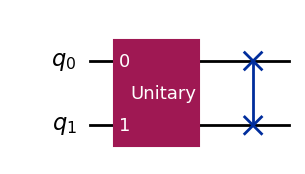

In [17]:
from qiskit import QuantumCircuit
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Operator, random_unitary
 
UU = random_unitary(4, seed=12345)
rand_U = UnitaryGate(UU)
 
qc = QuantumCircuit(2)
qc.append(rand_U, range(2))
qc.swap(0, 1)
qc.draw("mpl", style="iqp")

We'll use the FakeSherbrooke mock backend in our examples. First, let's transpile using optimization level 0.

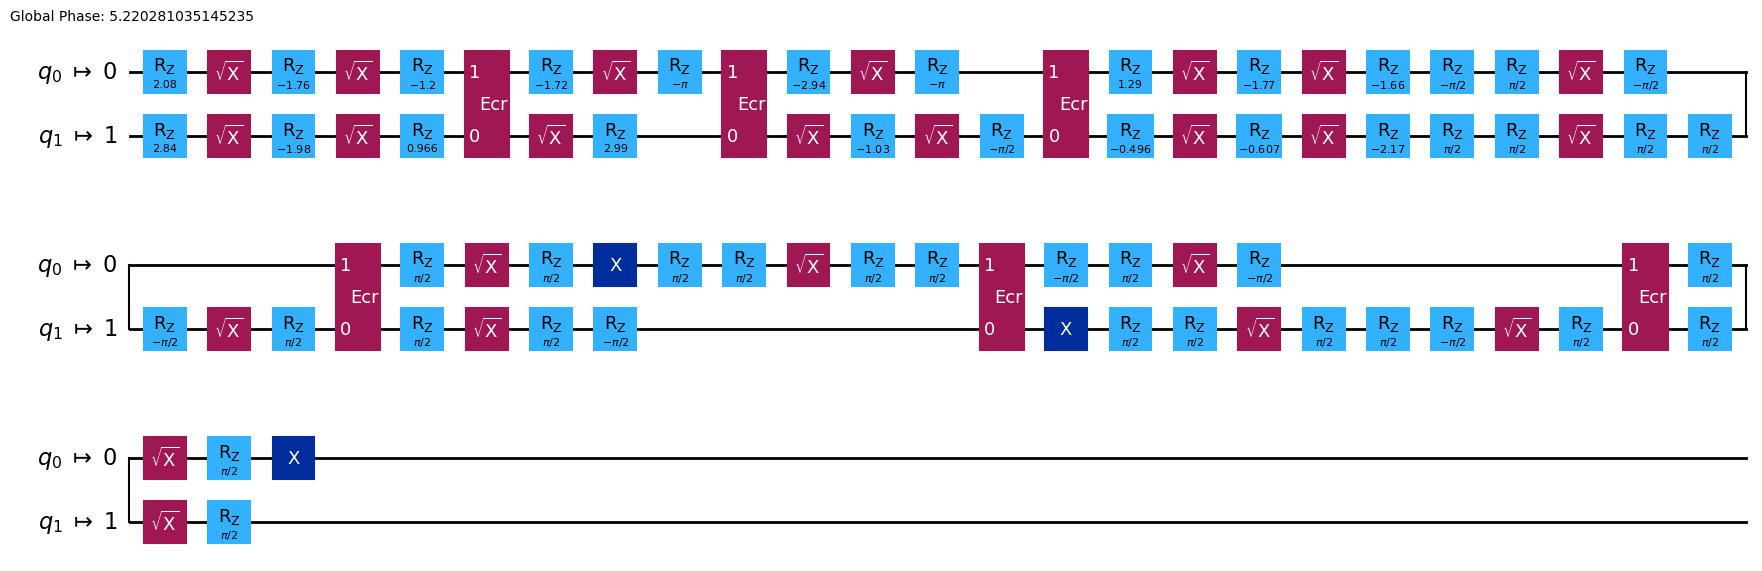

In [18]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
 
backend = FakeSherbrooke()
 
pass_manager = generate_preset_pass_manager(
    optimization_level=0, backend=backend, seed_transpiler=12345
)
qc_t1_exact = pass_manager.run(qc)
qc_t1_exact.draw("mpl", idle_wires=False)

The transpiled circuit has six of the two-qubit ECR gates.

Repeat for optimization level 1:

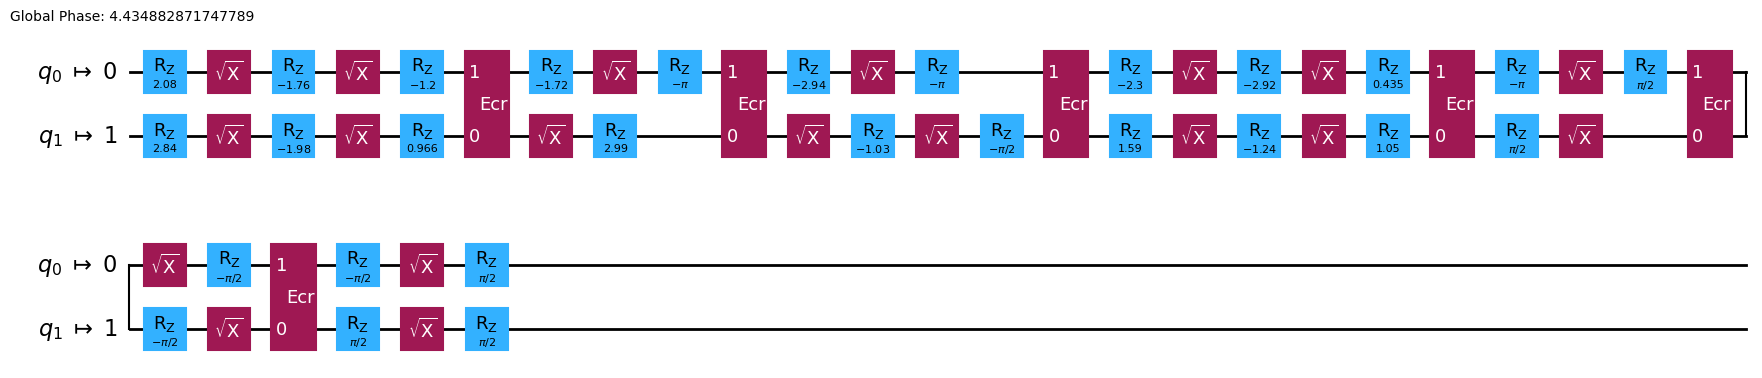

In [19]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime.fake_provider import FakeSherbrooke
 
backend = FakeSherbrooke()
 
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend, seed_transpiler=12345
)
qc_t1_exact = pass_manager.run(qc)
qc_t1_exact.draw("mpl", idle_wires=False)

The transpiled circuit still has six ECR gates, but the number of single-qubit gates has reduced.

Repeat for optimization level 2:

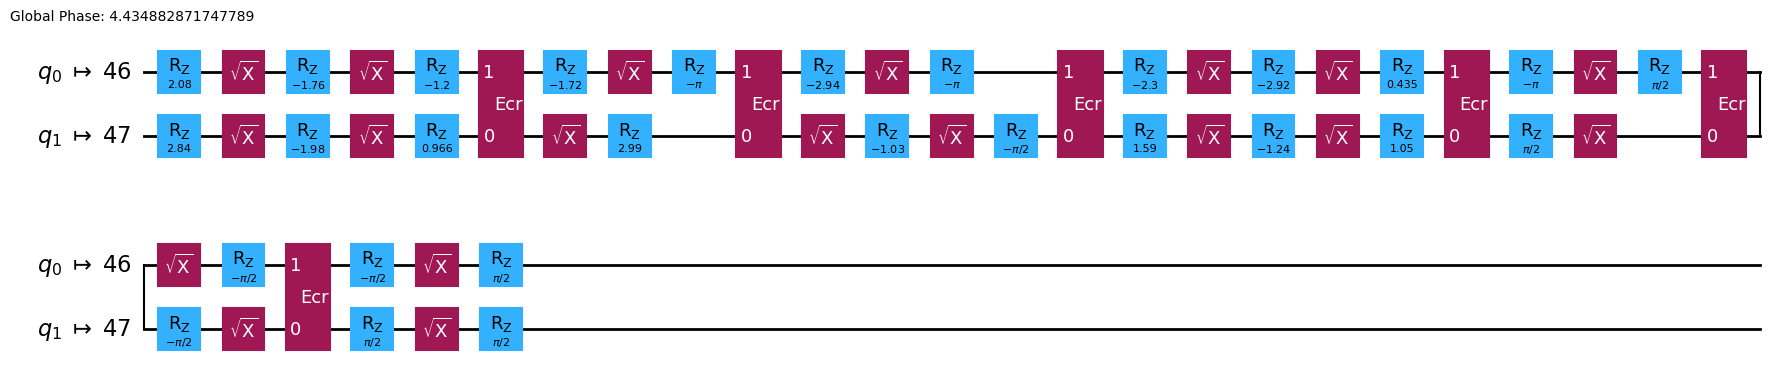

In [20]:
pass_manager = generate_preset_pass_manager(
    optimization_level=2, backend=backend, seed_transpiler=12345
)
qc_t2_exact = pass_manager.run(qc)
qc_t2_exact.draw("mpl", idle_wires=False)

This yields the same results as optimization level 1. Note that increasing the level of optimization does not always make a difference.

Repeat again, with optimization level 3:

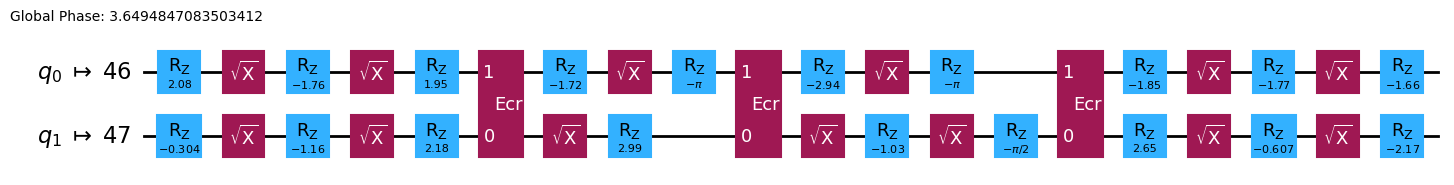

In [21]:
pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=backend, seed_transpiler=12345
)
qc_t3_exact = pass_manager.run(qc)
qc_t3_exact.draw("mpl", idle_wires=False)

Now, there are only three ECR gates. We obtain this result because at optimization level 3, Qiskit tries to re-synthesize two-qubit blocks of gates, and any two-qubit gate can be implemented using at most three ECR gates.

# Simulation using Qiskit primitives

In the verify phase, you test your quantum programs by running them on simulated devices and exploring their performance under realistic device noise models. This allows you to validate them before sending them to a physical system.

Quantum simulators can be used to help develop and test programs before fine-tuning them and sending them to quantum hardware. Local simulators can do this with good performance and efficiency.

Because the cost of classically simulating quantum circuits scales exponentially with the number of qubits, circuits that are larger than 50 qubits or so generally cannot be directly verified. For such circuits, you can:

- Test smaller versions of the circuits that can be simulated classically.
- Modify the circuits so that they become classically simulable and test these modified circuits.

Stabilizer circuits, also known as Clifford circuits, are a useful tool for accomplishing this latter goal. These are a restricted class of quantum circuits that can be efficiently simulated classically. Specialized simulators can easily simulate stabilizer circuits with thousands of qubits


# Exact simulation with Qiskit SDK primitives

The reference primitives in the Qiskit SDK perform local statevector simulations. These simulations do not support modeling device noise, but are useful for quickly prototyping algorithms before looking into more advanced simulation techniques (using Qiskit Aer) or running on real devices (Qiskit Runtime primitives).

The Estimator primitive can compute expectation values of circuits, and the Sampler primitive can sample from output distributions of circuits.

Let's see how to use the reference primitives to run your workflow locally

# Estimator primitive

Let us just create a circuit and a simple observable.

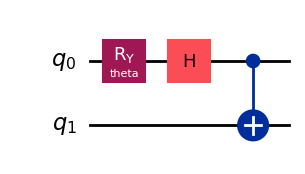

In [22]:
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
 
# circuit for which you want to obtain the expected value
qc = QuantumCircuit(2)
qc.ry(Parameter('theta'), 0)
qc.h(0)
qc.cx(0,1)
qc.draw("mpl", style="iqp")

In [23]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
 
# observable(s) whose expected values you want to compute
from qiskit.quantum_info import SparsePauliOp
observable = SparsePauliOp(["II", "XX", "YY", "ZZ"], coeffs=[1, 1, -1, 1])
 
# value(s) for the circuit parameter(s)
parameter_values = [[0], [np.pi/6], [np.pi/2]]

Now we can initialize the Estimator.

Note that the Qiskit Runtime primitives workflow requires circuits and observables to be transformed to only use instructions supported by the system (referred to as instruction set architecture (ISA) circuits and observables). The reference primitives still accept abstract instructions, as they rely on local statevector simulations, but transpiling the circuit might still be beneficial in terms of circuit optimization.

In [24]:
# Generate a pass manager without providing a backend
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(qc)
isa_observable = observable.apply_layout(isa_circuit.layout)

In [25]:
from qiskit.primitives import StatevectorEstimator
estimator = StatevectorEstimator()

In [26]:
job = estimator.run([(isa_circuit, isa_observable, parameter_values)])
result = job.result()
print(f" > Result class: {type(result)}")

 > Result class: <class 'qiskit.primitives.containers.primitive_result.PrimitiveResult'>


In [27]:
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: [4.         3.73205081 2.        ]
 > Metadata: {'precision': 0.0}


# Sampler primitive

Let's create a circuit. Notice that this time we don't need an observable, but we measure the final state by adding measurement gates in the circuit. In this case, we will compute the quasi-probability distributions from the measurement.

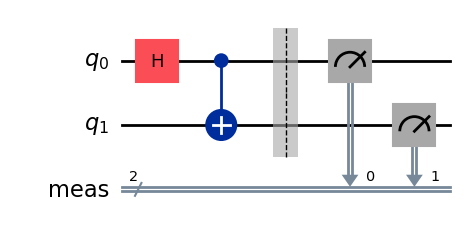

In [28]:
from qiskit import QuantumCircuit
 
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.measure_all()
qc.draw("mpl", style="iqp")

In [29]:
# Generate a pass manager without providing a backend
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
pm = generate_preset_pass_manager(optimization_level=1)
isa_circuit = pm.run(qc)
isa_observable = observable.apply_layout(isa_circuit.layout)

We can initialize the Sampler primitive.

In [30]:
from qiskit.primitives import StatevectorSampler
 
sampler = StatevectorSampler()

In [31]:
# execute 1 circuit with Sampler V2
job = sampler.run([isa_circuit]) 
pub_result = job.result()[0]
print(f" > Result class: {type(pub_result)}")

 > Result class: <class 'qiskit.primitives.containers.pub_result.PubResult'>


In [32]:
# Access bitstring for the classical register "meas"
bitstrings = pub_result.data.meas.get_bitstrings()
print(f"The number of bitstrings is: {len(bitstrings)}")
# Get counts for the classical register "meas"
counts = pub_result.data.meas.get_counts()
print(f"The counts are: {counts}")

The number of bitstrings is: 1024
The counts are: {'11': 512, '00': 512}


# Running a job on a quantum computer

- We have talked about how to run small instances locally on a simulator.

- However, we have discussed that in general, the circuits that has more than 50-60 qubits are very difficult or impossible to classically simulate.

- Our goal is to run the quantum circuits on an actual quantum computer.

- We will make two primary changes,

    1. Specify the backend (quantum device) to submit the job.
    2. Import the primitives (Sampler or Estimator) from the Qiskit Runtime Service. 

# Estimator examples

Efficiently calculate and interpret expectation values of the quantum operators required for many algorithms with Estimator. Explore uses in molecular modeling, machine learning, and complex optimization problems.

### Run a single experiment

Use Estimator to determine the expectation value of a single circuit-observable pair

In [34]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import SparsePauliOp, random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator
 
n_qubits = 50
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)
 
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
observable = SparsePauliOp("Z" * n_qubits)
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
isa_observable = observable.apply_layout(isa_circuit.layout)
 
estimator = Estimator(backend)
job = estimator.run([(isa_circuit, isa_observable)])
result = job.result()
 
print(f" > Expectation value: {result[0].data.evs}")
print(f" > Metadata: {result[0].metadata}")

 > Expectation value: [0.09330986]
 > Metadata: {'shots': 4096, 'target_precision': 0.015625, 'circuit_metadata': {}, 'resilience': {}, 'num_randomizations': 32}


# Sampler examples

Generate entire error-mitigated quasi-probability distributions sampled from quantum circuit outputs. Leverage Sampler’s capabilities for search and classification algorithms like Grover’s and QVSM.

### Run a single experiment

Use Sampler to return the measurement outcome as a quasi-probability distribution (V1) or as bitstrings or counts (V2) of a single circuit.

In [35]:
import numpy as np
from qiskit.circuit.library import IQP
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import random_hermitian
from qiskit_ibm_runtime import QiskitRuntimeService, SamplerV2 as Sampler
 
n_qubits = 50
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=n_qubits)
 
mat = np.real(random_hermitian(n_qubits, seed=1234))
circuit = IQP(mat)
circuit.measure_all()
 
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(circuit)
 
sampler = Sampler(backend)
job = sampler.run([isa_circuit])
result = job.result()
 
# Get results for the first (and only) PUB
pub_result = result[0]
 
print(f" > Counts: {pub_result.data.meas.get_counts()}")

 > Counts: {'10001110010101000100110001110100011110111011110111': 1, '11011011100101100011110001111111001111100001000111': 1, '10011011010101111110010111011111010001111101001111': 1, '11100010001110001100100100001010111110110001000111': 1, '10001100000100101010111001110101010110100011101111': 1, '01001010000000001000000010000010110011100001110001': 1, '01000111100001101100000000000011001010100001000111': 1, '11101110011111011010100001010010100110011101000111': 1, '00001110101100100100111101111000111010101011101110': 1, '10111010100110011000010011010111011111001110010001': 1, '11011000101110000100010101100100011110011100000010': 1, '01000100010000100010010001001011010110101010011111': 1, '00000101101111100011001111111111011011111101110101': 1, '11010100111100100000100101010111010101110000100101': 1, '11011111111100000101010101101010010110111010110101': 1, '11110001010011100010010111101111100110101010001101': 1, '01001000111001110000101000001010010010111101100101': 1, '101110001010011010

Most of the material here is curated from Qiskit Documentation. For further information about anything discussed in this notebook, please use the link https://docs.quantum.ibm.com/